# ControlNet in Diffusers 🧨

Ever since Stable Diffusion took the world by storm, people have been looking for ways to have more control over the results of the generation process. ControlNet provides a minimal interface allowing users to customize the generation process up to a great extent. With ControlNet, users can easily condition the generation with different spatial contexts such as a depth map, a segmentation map, a scribble, keypoints, and so on!

We can turn a cartoon drawing into a realistic photo with incredible coherence.

<div align="center">
    <table>
    <tr>
        <th>Realistic Lofi Girl</th>
    </tr>
    <tr>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/lofi.jpg" width=300/></td>
   </tr>
    </table>
</div>

Or even  use it as your interior designer.

<div align="center">
    <table>
    <tr>
        <th>Before</th>
        <th>After</th>
    </tr>
    <tr>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/house_depth.png" width=300/></td>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/house_after.jpeg" width=300/></td>
    </tr>
    </table>
</div>

You can turn your sketch scribble into an artistic drawing.

<div align="center">
    <table>
    <tr>
        <th>Before</th>
        <th>After</th>
    </tr>
    <tr>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/drawing_before.png" width=300/></td>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/drawing_after.jpeg" width=300/></td>
    </tr>
    </table>
</div>

Also, make some of the famous logos coming to life.

<div align="center">
    <table>
    <tr>
        <th>Before</th>
        <th>After</th>
    </tr>
    <tr>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/starbucks_logo.jpeg" width=300/></td>
        <td><img src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/starbucks_after.png" width=300/></td>
    </tr>
    </table>
</div>

With ControlNet, sky is the limit 🌠 

In this blog post, we first introduce the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) and then show how it can suit various controlled outputs. Let’s get controlling! 

## ControlNet: TL;DR

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) by Lvmin Zhang and Maneesh Agrawala. It introduces a framework that allows for supporting various spatial contexts that can serve as additional conditionings to Diffusion models such as Stable Diffusion. It is comprised of the following steps:

1. Cloning the pre-trained parameters of a Diffusion model such as Stable Diffusion (referred to as “trainable copy”) while also maintaining the pre-trained parameters separately (”locked copy”). It is done so that the locked parameter copy can preserve the vast knowledge learned from a large dataset, whereas the trainable copy is employed to learn task-specific aspects. 
2. The trainable and locked copies of the parameters are connected via “zero convolution” layers which are optimized as a part of the ControlNet framework. This is a training trick to preserve the semantics already learned by frozen model as the new conditions are trained.

Pictorially, it looks like so:

<p align="center">
    <img src="https://github.com/lllyasviel/ControlNet/raw/main/github_page/sd.png" alt="controlnet-structure"><br>
    <em>The diagram is taken from <a href=https://github.com/lllyasviel/ControlNet/blob/main/github_page/sd.png>here</a>.</em>
</p>

A sample from the training set for ControlNet-like training looks like this (additional conditioning is via edge maps):

<div align="center">
    <table>
    <tr>
        <th>Original Image</th>
        <th>Conditioning</th>
        <th>Prompt</th>
    </tr>
    <tr>
        <td><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_bird.png" width=200/></td>
        <td><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/canny_map.png" width=200/></td>
        <td>"bird"</td>
    </tr>
    </table>
</div>

Similarly, if we were to condition ControlNet with semantic segmentation maps, a training sample would be like so:

<div align="center">
    <table>
    <tr>
        <th>Original Image</th>
        <th>Conditioning</th>
        <th>Prompt</th>
    </tr>
    <tr>
        <td><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_house.png" width=300/></td>
        <td><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/segmentation_map.png" width=300/></td>
        <td>"big house"</td>
    </tr>
    </table>
</div>

Every new type of conditioning requires training a new copy of ControlNet weights. The paper proposed 8 different conditioning models that are all [supported](https://huggingface.co/lllyasviel?search=controlnet) in Diffusers! Trained ControlNet models are chosen during inference, as we will see below.

## The `StableDiffusionControlNetPipeline`

To experiment with ControlNet, we expose [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) similar to
the [other pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview) we offer from Diffusers. Central to the `StableDiffusionControlNetPipeline` is the `controlnet` argument which lets us provide a particular [`ControlNetModel`](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.ControlNetModel) instance trained on specific spatial contexts as conditioning. 

We will explore different use cases with the `StableDiffusionControlNetPipeline` in this blog post. The first ControlNet model we are going to walk through is the Canny model - this is one of the most popular models that generated some of the most amazing images you will see on the internet.

We welcome you to run the code snippets shown in the sections below with this Colab Notebook.

Before we begin, let's make sure we have all the necessary libraries installed:

In [ ]:
!pip install -qqq git+https://github.com/huggingface/diffusers.git transformers
!pip install -q git+https://github.com/huggingface/accelerate

We will also to install OpenCV and `controlnet-aux`:

In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

We will use the famous painting ["Girl With A Pearl"](https://en.wikipedia.org/wiki/Girl_with_a_Pearl_Earring) for this example. So, let's download the image and take a look:

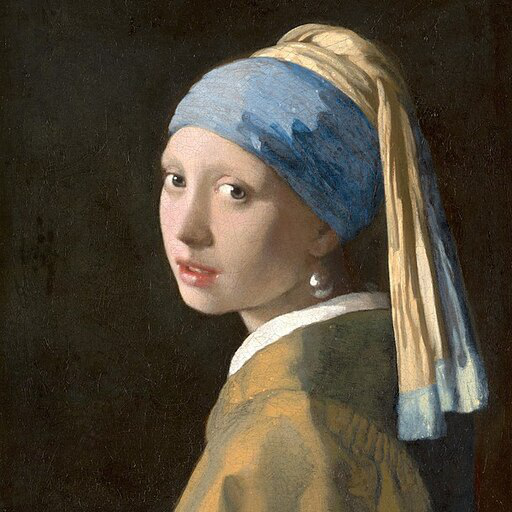

In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

Next, we will put the image through the canny pre-processor:

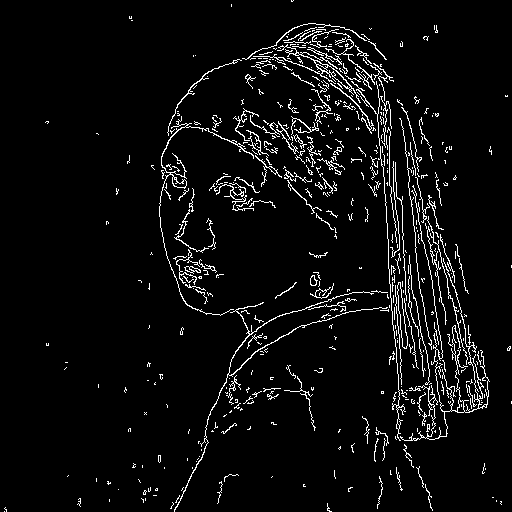

In [5]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

As we can see, it is essentially edge detection.

Now, we load the official Stable Diffusion 1.5 Model as well as the ControlNet model for canny edges.

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

To speed things up and reduce memory, let’s use the fast [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc) and enable model offloading.

In [7]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# This command loads the individual model components on GPU on-demand. So, we don't
# need to explicitly call pipe.to("cuda").
pipe.enable_model_cpu_offload()

Now we are ready to run the ControlNet pipeline!

We still provide a prompt to guide the image generation process, just like what we would normally do with a Stable Diffusion image-to-image pipeline. However, ControlNet will allow a lot more control over the generated image because we will be able to control the exact composition in generated image with the canny edge image we just created.

It will be fun to see some images where contemporary celebrities posing for this exact same painting from the 17th century. And it's really easy to do that with ControlNet, all we have to do is to include the names of these celebrities in the prompt!

  0%|          | 0/50 [00:00<?, ?it/s]

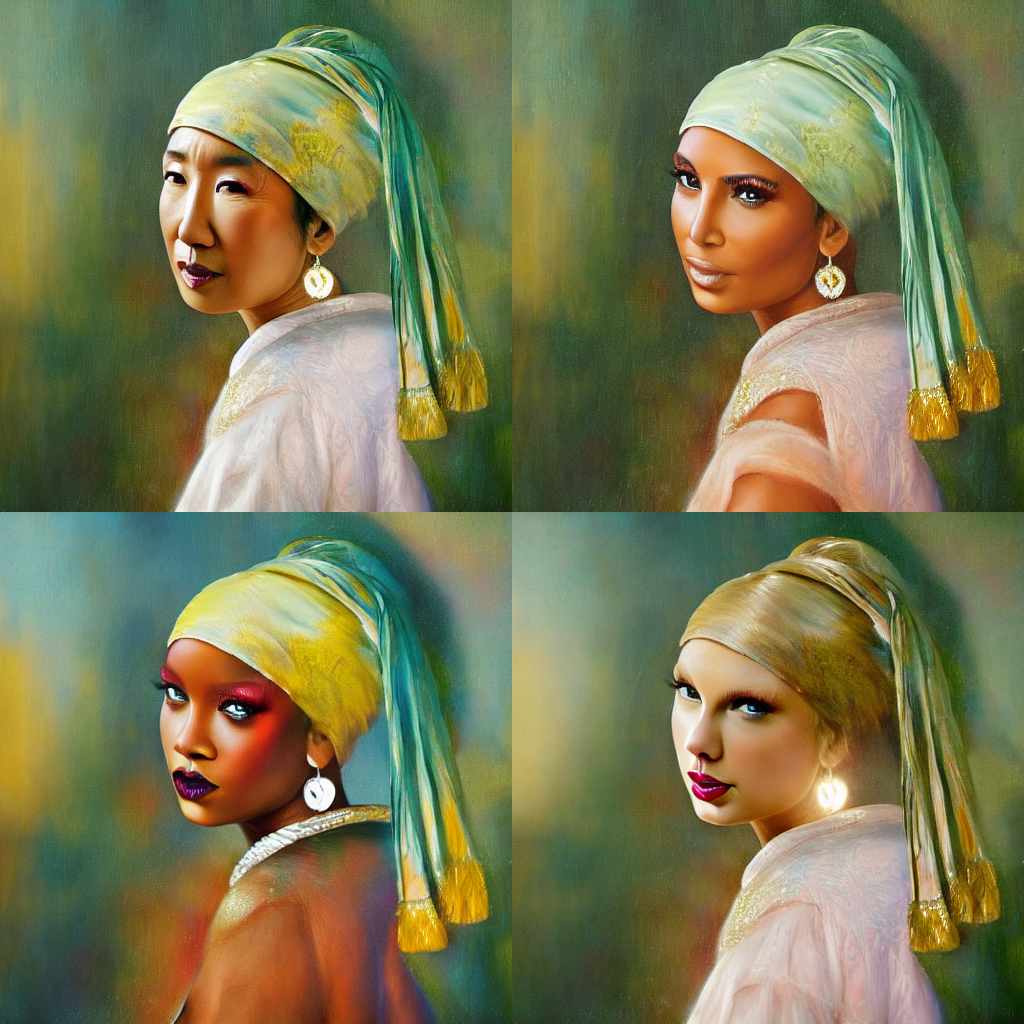

In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
)

image_grid(output.images, 2, 2)

We can effortlessly combine ControlNet combines with fine-tuning too! For example, we can fine-tune a model with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth), and use it to render ourselves into different scenes.

In this post, we are going to use our beloved Mr Potato Head as an example to show how to use ControlNet with DreamBooth.

We can use the same ContrlNet, however instead of using the Stable Diffusion 1.5, we are going to load the [Mr Potato Head model](https://huggingface.co/sd-dreambooth-library/mr-potato-head) into our pipeline - Mr Potato Head is a Stable Diffusion model fine-tuned with Mr Potato Head concept using Dreambooth 🥔

In [ ]:
model_id = "sd-dreambooth-library/mr-potato-head"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Now let's make Mr Potato posing for [Johannes Vermeer](https://en.wikipedia.org/wiki/Johannes_Vermeer)!

In [10]:
generator = torch.manual_seed(2)
prompt = "a photo of sks mr potato head, best quality, extremely detailed"
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
)

  0%|          | 0/50 [00:00<?, ?it/s]

It is noticeable that Mr Potato Head is not the best candidate but he tried his best and did a pretty good job in capture some of the essence 🍟

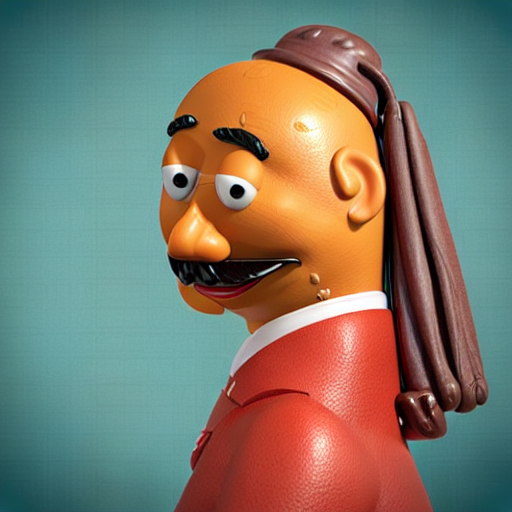

In [11]:
output.images[0]

It is noticeable that Mr Potato Head is not the best candidate but he tried his best and did a pretty good job in capture some of the essence 🍟

Another exclusive application of ControlNet is that we can take a pose from one image and reuse it to generate a different image with the exact same pose. So in this next example, we are going to teach a cute anime girl how to do yoga using [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose)!

First, we will need to get some images of people doing yoga:

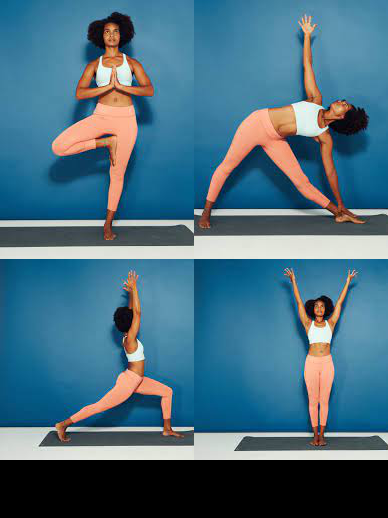

In [12]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) 
    for url in urls
]

image_grid(imgs, 2, 2)

Now let's extract yoga poses using the OpenPose pre-processors:

cuda


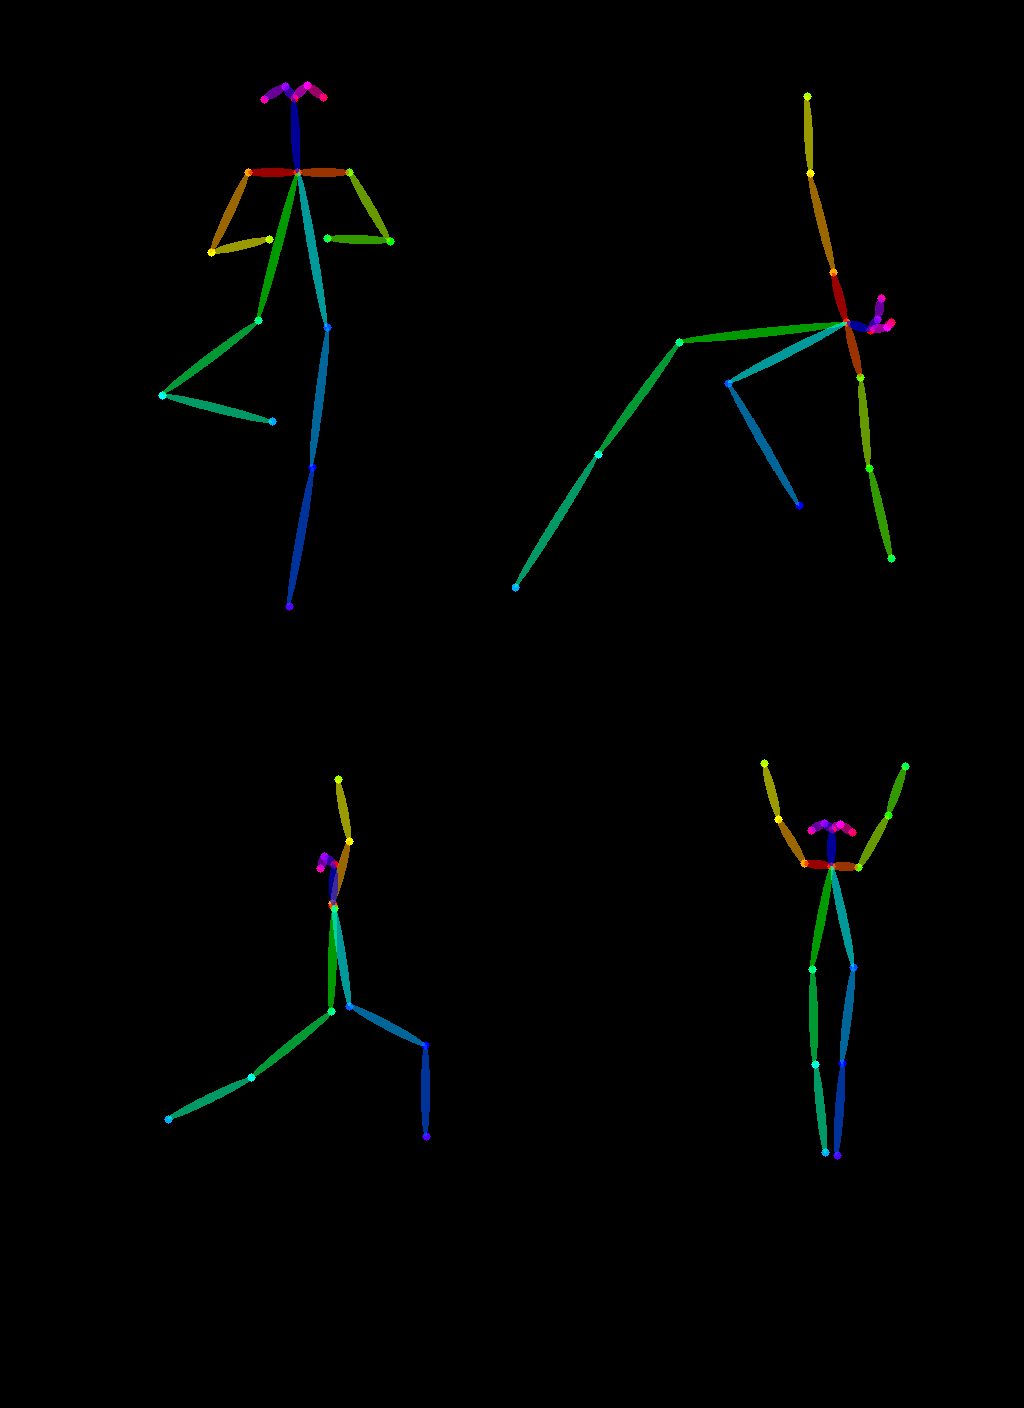

In [13]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

To use these yoga poses to generate new images, let's create a [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose). We are going to get our cute anime girl from [the Anything-V4 model](https://huggingface.co/andite/anything-v4.0). Let's go 🚀

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "andite/anything-v4.0"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Now it's yoga time! 

  0%|          | 0/50 [00:00<?, ?it/s]

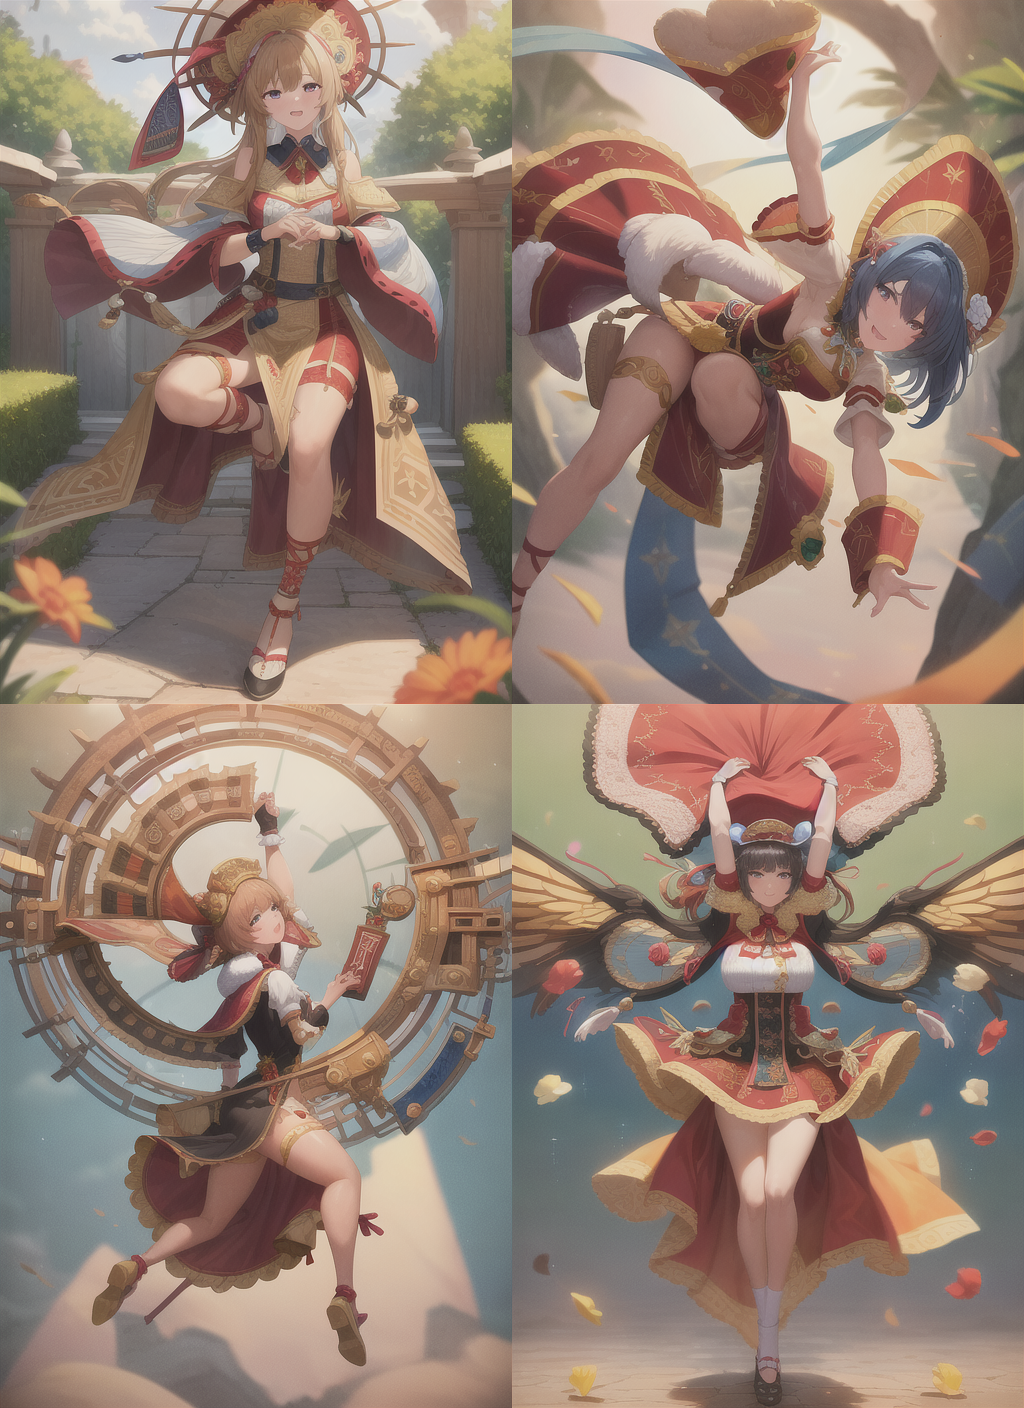

In [15]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = " best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
)
image_grid(output.images, 2, 2)

Throughout the examples, we explored multiple facets of the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) to show how easy and intuitive it is play around with ControlNet via Diffusers. However, we didn't cover all types of conditionings supported by ControlNet. To know more about those, we encourage you to check out the respective model documentation pages:

* [lllyasviel/sd-controlnet-depth](https://huggingface.co/lllyasviel/sd-controlnet-depth)
* [lllyasviel/sd-controlnet-hed](https://huggingface.co/lllyasviel/sd-controlnet-hed)
* [lllyasviel/sd-controlnet-normal](lllyasviel/sd-controlnet-normal)
* [lllyasviel/sd-controlnet-scribble](https://huggingface.co/lllyasviel/sd-controlnet-scribble)
* [lllyasviel/sd-controlnet-seg](https://huggingface.co/lllyasviel/sd-controlnet-scribble)
* [lllyasviel/sd-controlnet-openpose](https://huggingface.co/lllyasviel/sd-controlnet-openpose)
* [lllyasviel/sd-controlnet-mlsd](https://huggingface.co/lllyasviel/sd-controlnet-mlsd)
* [lllyasviel/sd-controlnet-mlsd](https://huggingface.co/lllyasviel/sd-controlnet-canny)

We welcome you to combine these different elements and share your results with [@diffuserslib](https://twitter.com/diffuserslib). Be sure to check out the Colab Notebook to take some of the above examples for a spin!

We also showed some techniques to make the generation process faster and memory-friendly by using a faster scheduler and smart model offloading. With these techniques combined the generation process takes just ~3 seconds in a V100 GPU and consumes just ~4 GBs of VRAM ⚡️

## Conclusion

We have been playing a lot with [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet), and our experience has been fun so far! We’re excited to see what the community builds on top of this pipeline. If you want to check out other pipelines and techniques supported in Diffusers that allow for controlled generation, check out our [official documentation](https://huggingface.co/docs/diffusers/main/en/using-diffusers/controlling_generation).